<a href="https://colab.research.google.com/github/arkothiwala/QuoraQuestionPairs/blob/master/QQP_firstSuccess_withManhatten.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Download (Competition Data, Embeddings)

Kaggle API Setup

In [0]:
!pip install kaggle
!mkdir ~/.kaggle
!cp ./kaggle.json ~/.kaggle/kaggle.json #Need to upload kaggle.json file from C:\Users\<USERNAME>\.kaggle\

mkdir: cannot create directory ‘/root/.kaggle’: File exists


### Download Competition Data

In [0]:
# Downloading Data
!kaggle competitions download -c quora-question-pairs
# Extracting the data
import zipfile
zip_ref = zipfile.ZipFile('train.csv.zip', 'r')
zip_ref.extractall()
zip_ref.close()
zip_ref = zipfile.ZipFile('test.csv.zip', 'r')
zip_ref.extractall()
zip_ref.close()

sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
 93% 105M/112M [00:02<00:00, 37.0MB/s] 
100% 112M/112M [00:03<00:00, 39.0MB/s]


### Download GloVe Embeddings

In [0]:
import progressbar
pbar = None

def show_progress(block_num, block_size, total_size):
    global pbar
    if pbar is None:
        pbar = progressbar.ProgressBar(maxval=total_size)

    downloaded = block_num * block_size
    if downloaded < total_size:
        pbar.update(downloaded)
    else:
        pbar.finish()
        pbar = None

In [0]:
# Lets Download GloVe Embeddings
import os
import urllib.request
print('downloading zipfile')
urllib.request.urlretrieve('http://nlp.stanford.edu/data/glove.840B.300d.zip', 'glove840B.zip', show_progress)
print('extracting zip file')
# Unzip the Embeddings
import zipfile
zip_ref = zipfile.ZipFile('glove840B.zip', 'r')
zip_ref.extractall('embeddings')
zip_ref.close()

downloading zipfile


100% (2176768927 of 2176768927) |########| Elapsed Time: 0:04:32 Time:  0:04:32


extracting zip file


### Load Embeddings

In [0]:
def load_embed(file):
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    if file == '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec':
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file) if len(o)>100)
    else:
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='latin'))
        
    return embeddings_index

# Load embedded vectors
glove = './embeddings/glove.840B.300d.txt'
#embed_glove = load_embed(glove) #We should load it only when required later

# Start Point of the Notebook

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import re
%matplotlib inline

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

#%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

In [0]:
train_df = pd.read_csv('train.csv').dropna()
#test_df = pd.read_csv('test.csv').dropna()
#test_df = pd.read_csv('../input/test.csv').dropna()
q1 = train_df.question1

## 1 Text Pre-processing

### 1.1. Put sentence between Start Stop Token

In [0]:
def addStartStopTokens(series):
    return '<start> ' + series.str.lower() + ' <stop>'

### 1.2. replace numbers with "number"

In [0]:
def replaceNumbers(series):
    # Space around number is added to ensure that
    # number was a single entity and not with a word (e.g. F1 visa, Audi A4)
    total = series.str.contains(' [\d]+ ').sum()
    print("{:.2f} % queries with numbers were processed".format(total*100/len(series)))
    return series.str.replace(' [+-]?([0-9]*[.])?[0-9]+ ',' number ')#.replace(' [\d]+(.[\d]+) ',' number ') # Still misses case of float numbers

### 1.3. add space around non alpha-numeric chars

In [0]:
def processNonAlNumChars(series):
    # '\1' does not work with out `r` prefix and () grouping
    return series.str.replace(r'([^0-9a-zA-Z\' ]+)',r' \1 ') 

### 1.4. ephostropis

1. Three (including apostrophe) long: I'm, I'd
2. Four long: it's, I've, he's, I'll, he'd, we'd, it'd
3. Five long: don't, can't, we're, isn't, won't, we've, we'll, she's, you'd, let's, who's, he'll, it'll, she'd, ain't, who'd
4. Six long: that's, didn't, you're, you'll, what's, wasn't, you've, aren't, here's, hasn't, hadn't, they'd, here's, who've, she'll, who'll, that'd
5. Seven long: doesn't, there's, they're, world's, haven't, they've, weren't, they'll, o'clock, mustn't, needn't, must've, that'll
6. Eight long: couldn't, wouldn't, could've, would've, there'll
7. Nine long: shouldn't, should've

Most of the words follow certain pattern with certain exceptions like let's, can't, ain't, shan't - can be ignored<br>
These words needs to be converted first

In [0]:
def processAphostrophies(series):
    '''
    Before calling this function, make sure that `space around alphaNum chars are not added`
    '''
    series = series.str.replace(" can't ", ' cannot ')
    series = series.str.replace(" ain't ", ' arenot ')
    series = series.str.replace(" won't ", ' willnot ')
    series = series.str.replace(" let's ", ' letus ')# Should I have preceeding space ? (fails for i'm a boy)
    series = series.str.replace(r"([a-z]+)'m ", r"\1 am ")
    series = series.str.replace(r"([a-z]+)'d ", r"\1 had ")
    series = series.str.replace(r"([a-z]+)'s ", r"\1 is ")
    series = series.str.replace(r"([a-z]+)'ve ", r"\1 have ")
    series = series.str.replace(r"([a-z]+)'ll ", r"\1 will ")
    series = series.str.replace(r"([a-z]+)n't ", r"\1 not ")
    series = series.str.replace(r"([a-z]+)'re ", r"\1 are ")
    return series

### 1.5 - Remove non-ASCII charecters

In [0]:
def removeNonASCII(series):
    return series.str.replace(r'[^\x00-\x7F]+',' ')

### 1.6 - Price related preprocessing (20k, 100m / 100mn, 2b / 1bn)

In [0]:
def processPriceAcronyms(series):
    series = series.str.replace(r" ([\d]+)(k|m|mn|b|bn) ",r" \1 ") #While fixing 10k, 5bn i found mg, kg, mb etc
    #series.str.replace(r"([\d]+)([a-z]{1,2,3})",r" \1 \2 ") # generalizes upto 3 chars (to include kgs, rpm as well)
    return series.str.replace(r"([\d]+)(mg|gm|kg|kb|mb|gb|tb)",r" \1 \2 ") #targets only specific words

### 1.7 - misc

In [0]:
def alternatives(series):
    series = series.str.replace(r"(no|some|any)body",r"\1one")

## 2. Processing

In [0]:
def cleanText(series):
    series = addStartStopTokens(series)
    series = replaceNumbers(series)
    series = processNonAlNumChars(series) # It will seperate apostrophies as well
    series = replaceNumbers(series)

    series = processAphostrophies(series)
    series = replaceNumbers(series)

    series = series.str.replace("'"," ' ")
    series = removeNonASCII(series)
    series = replaceNumbers(series)

    series = processPriceAcronyms(series)
    series = replaceNumbers(series)
    series = series.str.replace(r"[ ]+"," ")
    return series    

In [81]:
cleanedQ1 = cleanText(train_df.question1)
cleanedQ2 = cleanText(train_df.question2)

5.57 % queries with numbers were processed
4.60 % queries with numbers were processed
0.00 % queries with numbers were processed
0.11 % queries with numbers were processed
0.44 % queries with numbers were processed
5.81 % queries with numbers were processed
4.76 % queries with numbers were processed
0.01 % queries with numbers were processed
0.11 % queries with numbers were processed
0.45 % queries with numbers were processed


In [82]:
cleanedQ1_test = cleanText(test_df.question1)
cleanedQ2_test = cleanText(test_df.question2)

KeyboardInterrupt: ignored

In [0]:
cleanedQ1 = cleanedQ1.str.replace(' < start > ','')
cleanedQ1 = cleanedQ1.str.replace(' < stop > ','')
cleanedQ2 = cleanedQ2.str.replace(' < start > ','')
cleanedQ2 = cleanedQ2.str.replace(' < stop > ','')

In [0]:
cleanedQ1_test = cleanedQ1_test.str.replace(' < start > ','')
cleanedQ1_test = cleanedQ1_test.str.replace(' < stop > ','')
cleanedQ2_test = cleanedQ2_test.str.replace(' < start > ','')
cleanedQ2_test = cleanedQ2_test.str.replace(' < stop > ','')

In [0]:
train_df.question1 = cleanedQ1
train_df.question2 = cleanedQ2

In [0]:
test_df.question1 = cleanedQ1_test
test_df.question2 = cleanedQ2_test

In [90]:
train_df.dtypes

id               int64
qid1             int64
qid2             int64
question1       object
question2       object
is_duplicate     int64
dtype: object

In [0]:
assert type(train_df.question1.iloc[1]) == str, "question1 should be of type string"
assert type(train_df.question2.iloc[1]) == str, "question2 should be of type string"

In [0]:
train_df.to_csv('processed questions train.csv')

### Now we have processed data and will not get back again

## 3. Score Calculation

### 3.1 Processing for only score calculation

In [91]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
#stop_words = set(stopwords.words('english'))
stop_words = ['a', 'an', 'the', 'i', 'my','me','we', 'u', 'you', 'your', 'he', 'his', 'him', 'she', 'her', 'they', 'them', 'y']
# Should we remove is, are, of, by, it, its, to, in etc. ?

In [93]:
sentences_q1 = train_df.question1.str.replace(r'([^0-9a-zA-Z ]+)',r' ').str.replace(r"[ ]+"," ").to_numpy() # Remove NonAlNum Chars 
filtered_sentences_q1 = []

for sentence in tqdm(sentences_q1):
    filtered_sentence = [w for w in word_tokenize(sentence) if not w in stop_words] 
    filtered_sentences_q1.append(filtered_sentence)

In [0]:
assert type(filtered_sentences_q1[0]) == list, "filtered sentence must be of type list"

In [95]:
sentences_q2 = train_df.question2.str.replace(r'([^0-9a-zA-Z ]+)',r' ').str.replace(r"[ ]+"," ").to_numpy() # Remove NonAlNum Chars 
filtered_sentences_q2 = []

for sentence in tqdm(sentences_q2):
  try:
    filtered_sentence = [w for w in word_tokenize(sentence) if not w in stop_words] 
    filtered_sentences_q2.append(filtered_sentence)
  except:
    print(sentence)

In [0]:
assert type(filtered_sentences_q2[0]) == list, "filtered sentence must be of type list"

In [0]:
sentences_q1_test = cleanedQ1_test.str.replace(r'([^0-9a-zA-Z ]+)',r' ').str.replace(r"[ ]+"," ").to_numpy() # Remove NonAlNum Chars 
filtered_sentences_q1_test = []

for sentence in tqdm(sentences_q1_test):
    filtered_sentence = [w for w in word_tokenize(sentence) if not w in stop_words] 
    filtered_sentences_q1_test.append(filtered_sentence)

In [0]:
sentences_q2_test = cleanedQ2_test.str.replace(r'([^0-9a-zA-Z ]+)',r' ').str.replace(r"[ ]+"," ").to_numpy() # Remove NonAlNum Chars 
filtered_sentences_q2_test = []

for sentence in tqdm(sentences_q2_test):
    filtered_sentence = [w for w in word_tokenize(sentence) if not w in stop_words] 
    filtered_sentences_q2_test.append(filtered_sentence)

#### Calculating Scores

In [0]:
def calcScores(filteredSentences1,filteredSentences2):
  scores_wo_weight = []
  scores_pow1 = [] # Score with exp weight of power 1
  scores_pow2 = [] # Score with exp weight of power 2
  #for q1, q2 in tqdm(zip(filtered_sentences_q1,filtered_sentences_q2)):
  for q1, q2 in tqdm(zip(filteredSentences1,filteredSentences2)):
    l1 = len(q1)
    l2 = len(q2)
    if(l1 == 0 or l2 == 0):
        # There some points in data with single chars like ? . ! etc as Q1 or Q2 that endup with expty string
        scores_wo_weight.append(0)
        scores_pow1.append(0)
        scores_pow2.append(0)
    else:
        overlap = len(set(q1) & set(q2))
        weight_pow1 = np.power(np.e, -1/(np.sqrt(l1*l2)))
        weight_pow2 = np.power(np.e, -2/(np.sqrt(l1*l2)))
        if(weight_pow1 > 1 or weight_pow2 > 1):
            print(weight_pow1,weight_pow2)
            print(q1, q2)
        normalizer = 1/np.sqrt(l1*l2)
        scores_wo_weight.append(overlap*normalizer)
        scores_pow1.append(overlap*normalizer*weight_pow1)
        scores_pow2.append(overlap*normalizer*weight_pow2)   
  return scores_wo_weight, scores_pow1, scores_pow2

In [98]:
scores_wo_weight, scores_pow1, scores_pow2 = calcScores(filtered_sentences_q1, filtered_sentences_q2)

In [0]:
scores_wo_weight_test, scores_pow1_test, scores_pow2_test = calcScores(filtered_sentences_q1_test, filtered_sentences_q2_test)

### Weight Plot Function
<img src="https://github.com/arkothiwala/QuoraQuestionPairs/blob/master/exponential_weight_plot_desmos%20-%20Copy.png?raw=1">

In [0]:
import matplotlib.pyplot as plt

In [0]:
train_df['scores_wo_weight'] = scores_wo_weight
train_df['scores_pow1'] = scores_pow1
train_df['scores_pow2'] = scores_pow2
train_df['q1_tokens'] = filtered_sentences_q1
train_df['q2_tokens'] = filtered_sentences_q2

In [0]:
train_df.to_csv('processed_with_weights.csv')

In [0]:
test_df['scores_wo_weight'] = scores_wo_weight_test
test_df['scores_pow1'] = scores_pow1_test
test_df['scores_pow2'] = scores_pow2_test
test_df['q1_tokens'] = filtered_sentences_q1_test
test_df['q2_tokens'] = filtered_sentences_q2_test

In [47]:
filtered_sentences_q1_test[:1]

NameError: ignored

In [0]:
test_df.head()

In [0]:
test_df.drop(test_df.columns[[1, 2]], axis=1).head()


,test_id,scores_wo_weight,scores_pow1,scores_pow2,q1_tokens,q2_tokens
0,0,0.900000,0.814354,0.736858,"[how, does, surface, pro, himself, number, com...","[how, does, surface, pro, himself, number, com..."
1,1,1.000000,0.920044,0.846482,"[should, have, hair, transplant, at, age, numb...","[should, have, hair, transplant, at, age, numb..."
2,2,0.916667,0.843374,0.775942,"[what, but, is, best, way, to, send, money, fr...","[what, but, is, best, way, to, send, money, fr..."
3,3,1.000000,0.778801,0.606531,"[which, food, not, emulsifiers]","[which, food, not, emulsifiers]"
4,4,1.000000,0.778801,0.606531,"[how, aberystwyth, start, reading]","[how, aberystwyth, start, reading]"


In [0]:
test_df.drop(test_df.columns[[1, 2]], axis=1).to_csv('processed_with_weights_test.csv')

In [0]:
import gc
del scores_wo_weight_test, scores_pow1_test, scores_pow2_test, scores_wo_weight, scores_pow1, scores_pow2
del filtered_sentences_q1_test, filtered_sentences_q2_test, filtered_sentences_q1, filtered_sentences_q2
del sentences_q2_test, sentences_q1_test, sentences_q1, sentences_q2
del cleanedQ1_test, cleanedQ2_test, cleanedQ1, cleanedQ2
gc.collect()

72

### Huge mistake that I had made in score calculation (one silly and other conceptual)

When creating a new column for scores_wo_weight, scores_pow1, scores_pow2... I had created something like pd.Series(scores_wo_weight) and so... 

1) Conceptual Mistake: Now the problem that happend was with <b>dropna</b>. It had dropped perticular indexes from df... When creating a series, it recreated indexes and assigned values accordingly... So I had three lines in the last rows being NaN for scores... The fix was to assign array directly and it took care of indexes

2) Silly Mistake: when l1 or l2 was zero I was appending 0 <b>twice</b> in scores_pow1 instead of once in both <b>scores_pow1</b> and <b>scores_pow2</b>

In [0]:
plt.figure(figsize=(12,16))
plt.suptitle("Question Pair OverlapScore Distribution", size=20)
plt.subplot(3,2,1)
plt.title('IsDuplicate = 0 & NoWeight')
train_df[train_df.is_duplicate == 0].scores_pow2.hist(bins=20)
plt.subplot(3,2,2)
plt.title('IsDuplicate = 1 & NoWeight')
train_df[train_df.is_duplicate == 1].scores_pow2.hist(bins=20)
plt.subplot(3,2,3)
plt.title('IsDuplicate = 0 & P1 Exp Decay')
train_df[train_df.is_duplicate == 0].scores_wo_weight.hist(bins=20)
plt.subplot(3,2,4)
plt.title('IsDuplicate = 1 & P1 Exp Decay')
train_df[train_df.is_duplicate == 1].scores_wo_weight.hist(bins=20)
plt.subplot(3,2,5)
plt.title('IsDuplicate = 0 & P2 Exp Decay')
train_df[train_df.is_duplicate == 0].scores_pow1.hist(bins=20)
plt.subplot(3,2,6)
plt.title('IsDuplicate = 1 & P2 Exp Decay')
train_df[train_df.is_duplicate == 1].scores_pow1.hist(bins=20)
plt.show()

In [0]:
x = train_df[train_df.is_duplicate == 0]

In [0]:
x[x.scores_pow2 > 0.8][['q1_tokens','q2_tokens']].head()

## 4 .Creating Vocabulary and WordEmbedding

In [0]:
glove = './embeddings/glove.840B.300d.txt'
glove_embed = load_embed(glove)

In [0]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()

In [0]:
train_df = pd.read_csv('./processed_with_weights.csv')
#test_df = pd.read_csv('./processed_with_weights_test.csv')

In [5]:
train_df.head()

,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate,scores_wo_weight,scores_pow1,scores_pow2,q1_tokens,q2_tokens
0,0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.836242,0.769156,0.707452,"['what', 'is', 'step', 'by', 'step', 'guide', ...","['what', 'is', 'step', 'by', 'step', 'guide', ..."
1,1,1,3,4,what is the story of kohinoor ( koh - i - noor...,what would happen if the indian government sto...,0,0.510310,0.460797,0.416087,"['what', 'is', 'story', 'of', 'kohinoor', 'koh...","['what', 'would', 'happen', 'if', 'indian', 'g..."
2,2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.400000,0.361935,0.327492,"['how', 'can', 'increase', 'speed', 'of', 'int...","['how', 'can', 'internet', 'speed', 'be', 'inc..."
3,3,3,7,8,why am i mentally very lonely ? how can i solv...,find the remainder when [ math ] number ^{ num...,0,0.000000,0.000000,0.000000,"['why', 'am', 'mentally', 'very', 'lonely', 'h...","['find', 'remainder', 'when', 'math', 'number'..."
4,4,4,9,10,"which one dissolve in water quikly sugar , sal...",which fish would survive in salt water ?,0,0.419314,0.377583,0.340006,"['which', 'one', 'dissolve', 'in', 'water', 'q...","['which', 'fish', 'would', 'survive', 'in', 's..."


In [0]:
import pickle

# loading
try:
  with open('tokenizer.pickle', 'rb') as handle:
      tokenizer = pickle.load(handle)
except:
  tokenizer.fit_on_texts(list(train_df.q1_tokens) + list(train_df.q2_tokens) + list(test_df.q1_tokens) + list(test_df.q2_tokens))
  # saving
  with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
from ast import literal_eval
train_seq_q1 = [tokenizer.texts_to_sequences(literal_eval(x)) for x in train_df.q1_tokens]
train_seq_q2 = [tokenizer.texts_to_sequences(literal_eval(x)) for x in train_df.q2_tokens]

#train_seq_q1 = tokenizer.texts_to_sequences(train_df.q1_tokens.to_numpy())
#train_seq_q2 = tokenizer.texts_to_sequences(train_df.q2_tokens.to_numpy())

In [44]:
test_seq_q1 = tokenizer.texts_to_sequences(test_df.q1_tokens)
test_seq_q2 = tokenizer.texts_to_sequences(test_df.q2_tokens)

NameError: ignored

In [0]:
lens = list(map(lambda x: len(x), train_seq_q1))

In [0]:
sum(np.array(lens) >= 32)*100/len(train_seq_q1)

(30, 70)

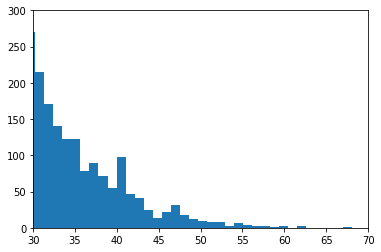

In [0]:
plt.hist(lens, bins=100)
plt.ylim(0,300)
plt.xlim(30,70)

### Create Embedding Matrix

In [20]:
print(len(tokenizer.index_word))
max_features = len(tokenizer.index_word)
maxlen = 32

116082


In [23]:
all_embs = np.stack(glove_embed.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = glove_embed.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


### Pad Sentences

In [24]:
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [0]:
train_seq_q1 = pad_sequences(train_seq_q1, maxlen = maxlen)
train_seq_q2 = pad_sequences(train_seq_q2, maxlen = maxlen)

In [47]:
print('the data is in shape : {} which we need to transform in to shape of : {}'.format(train_seq_q1.shape,train_seq_q1.shape[:2]))
train_seq_q1 = train_seq_q1.reshape((train_seq_q1.shape[0], train_seq_q1.shape[1]))
train_seq_q2 = train_seq_q2.reshape((train_seq_q2.shape[0], train_seq_q2.shape[1]))

the data is in shape : (404287, 32, 1) which we need to transform in to shape of : (404287, 32)


(404287, 32, 1)

### Model Building

In [0]:
from keras.layers import Input, Embedding, Bidirectional, GlobalMaxPool1D, CuDNNGRU, LSTM
from keras.layers import Dense, Dropout, Subtract, CuDNNLSTM, Lambda
from keras.models import Model
from keras import backend as K

In [0]:
max_seq_length = maxlen
def getModel_medium():
  # The visible layer
  left_input = Input(shape=(max_seq_length,), dtype='int32')
  right_input = Input(shape=(max_seq_length,), dtype='int32')

  embedding_layer = Embedding(max_features, embed_size, weights=[embedding_matrix], input_length=max_seq_length, trainable=False)

  # Embedded version of the inputs
  encoded_left = embedding_layer(left_input)
  encoded_right = embedding_layer(right_input)

  # Since this is a siamese network, both sides share the same LSTM
  shared_lstm = CuDNNLSTM(32,  name='lstm')

  left_output = shared_lstm(encoded_left)
  right_output = shared_lstm(encoded_right)

  # Calculates the distance as defined by the MaLSTM model
  malstm_distance = Lambda(function=lambda a: exponent_neg_manhattan_distance(a[0], a[1]),output_shape=lambda b: (b[0][0], 1))([left_output, right_output])

  # Pack it all up into a model
  model = Model([left_input, right_input], [malstm_distance])
  print('medium')
  print(model.summary())
  return model

In [0]:
def getModel():
  inp_q1 = Input(shape=(maxlen,))
  inp_q2 = Input(shape=(maxlen,))
  embedding_layer = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)
  x1 = embedding_layer(inp_q1)
  x2 = embedding_layer(inp_q2)
  BiDirRNN = Bidirectional(CuDNNLSTM(32, return_sequences=True))
  x1 = BiDirRNN(x1)
  x1 = GlobalMaxPool1D()(x1)
  x2 = BiDirRNN(x2)
  x2 = GlobalMaxPool1D()(x2)
  x = Subtract()([x1,x2])
  x = Dense(16, activation="relu")(x)
  x = Dropout(0.1)(x)
  x = Dense(1, activation="sigmoid")(x)
  model = Model(inputs=[inp_q1, inp_q2], outputs=x)
  #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  print(model.summary())
  return model

In [0]:
def getModel():
  inp_q1 = Input(shape=(maxlen,))
  inp_q2 = Input(shape=(maxlen,))
  embedding_layer = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)
  x1 = embedding_layer(inp_q1)
  x2 = embedding_layer(inp_q2)
  BiDirRNN = Bidirectional(CuDNNLSTM(32, return_sequences=True))
  x1 = BiDirRNN(x1)
  x1 = GlobalMaxPool1D()(x1)
  x2 = BiDirRNN(x2)
  x2 = GlobalMaxPool1D()(x2)
  malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([x1, x2])
  #x = Subtract()([x1,x2])
  #x = Dense(16, activation="relu")(x)
  #x = Dropout(0.1)(x)
  #x = Dense(1, activation="sigmoid")(x)
  model = Model(inputs=[inp_q1, inp_q2], outputs=[malstm_distance])
  #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  print(model.summary())
  return model

In [0]:
def exponent_neg_manhattan_distance(left, right):
  return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

In [53]:
model = getModel_medium()

medium
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 32, 300)      34824600    input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lstm (CuDNNLSTM)                (None, 32)           42752       embedding_3[0][0]                
   

In [0]:
from keras.optimizers import Adadelta
optimizer = Adadelta(clipnorm=0.9, lr=0.1)
#model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [50]:
print(train_seq_q2[:2], train_seq_q1[:2])

[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     1     2  1189
     52  1189  2808     5   550     4   712   344]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     1    40   191    20
     77   282 12188 16638 11427 21002  4555   174]] [[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     1     2  1189    52  1189
   2808     5   550     4   712   344     4    30]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      1     2   478     7 16638 11427 21002  4555]]


In [55]:
history = model.fit(x=[train_seq_q1, train_seq_q2], y=train_df.is_duplicate.to_numpy(), epochs=50, batch_size=256, validation_split=0.3)

Train on 283000 samples, validate on 121287 samples
Epoch 1/50
283000/283000 [==============================] - 10s 35us/step - loss: 0.7206 - acc: 0.6803 - val_loss: 0.6573 - val_acc: 0.6947
Epoch 2/50
283000/283000 [==============================] - 9s 33us/step - loss: 0.6454 - acc: 0.6956 - val_loss: 0.6284 - val_acc: 0.7015
Epoch 3/50
283000/283000 [==============================] - 9s 33us/step - loss: 0.6238 - acc: 0.7020 - val_loss: 0.6124 - val_acc: 0.7071
Epoch 4/50
283000/283000 [==============================] - 9s 33us/step - loss: 0.6097 - acc: 0.7075 - val_loss: 0.6000 - val_acc: 0.7122
Epoch 5/50
283000/283000 [==============================] - 9s 33us/step - loss: 0.5973 - acc: 0.7131 - val_loss: 0.5884 - val_acc: 0.7181
Epoch 6/50
283000/283000 [==============================] - 9s 33us/step - loss: 0.5877 - acc: 0.7190 - val_loss: 0.5807 - val_acc: 0.7232
Epoch 7/50
283000/283000 [==============================] - 9s 33us/step - loss: 0.5809 - acc: 0.7238 - val_loss:

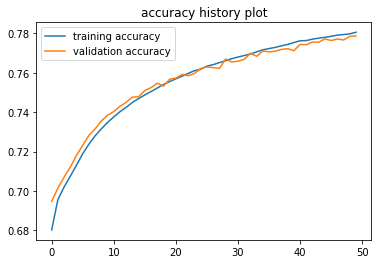

In [60]:
plt.title("accuracy history plot")
plt.plot(history.history['acc'], label='training accuracy')
plt.plot(history.history['val_acc'], label='validation accuracy')
plt.legend()

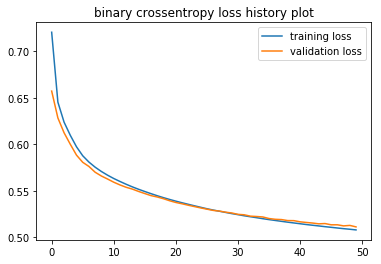

In [62]:
plt.title("binary crossentropy loss history plot")
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()

In [63]:
history_50_to_150 = model.fit(x=[train_seq_q1, train_seq_q2], y=train_df.is_duplicate.to_numpy(), epochs=150, batch_size=256, validation_split=0.3)

Train on 283000 samples, validate on 121287 samples
Epoch 1/150
283000/283000 [==============================] - 10s 35us/step - loss: 0.5073 - acc: 0.7810 - val_loss: 0.5121 - val_acc: 0.7796
Epoch 2/150
283000/283000 [==============================] - 10s 34us/step - loss: 0.5067 - acc: 0.7816 - val_loss: 0.5104 - val_acc: 0.7784
Epoch 3/150
283000/283000 [==============================] - 10s 34us/step - loss: 0.5061 - acc: 0.7815 - val_loss: 0.5105 - val_acc: 0.7784
Epoch 4/150
283000/283000 [==============================] - 9s 33us/step - loss: 0.5055 - acc: 0.7822 - val_loss: 0.5094 - val_acc: 0.7789
Epoch 5/150
283000/283000 [==============================] - 9s 33us/step - loss: 0.5050 - acc: 0.7830 - val_loss: 0.5099 - val_acc: 0.7806
Epoch 6/150
283000/283000 [==============================] - 9s 33us/step - loss: 0.5044 - acc: 0.7831 - val_loss: 0.5110 - val_acc: 0.7753
Epoch 7/150
283000/283000 [==============================] - 9s 33us/step - loss: 0.5039 - acc: 0.7834 - 

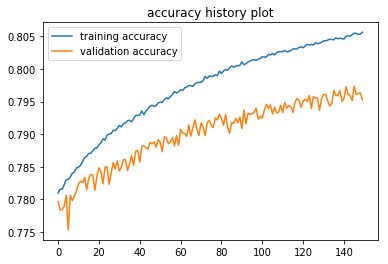

In [67]:
plt.title("accuracy history plot")
plt.plot(history_50_to_150.history['acc'], label='training accuracy')
plt.plot(history_50_to_150.history['val_acc'], label='validation accuracy')
plt.legend()

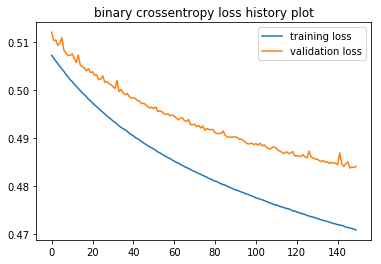

In [65]:
plt.title("binary crossentropy loss history plot")
plt.plot(history_50_to_150.history['loss'], label='training loss')
plt.plot(history_50_to_150.history['val_loss'], label='validation loss')
plt.legend()

In [0]:
train_df.is_duplicate.to_numpy()[:10]

In [0]:
import tensorflow as tf
l = model.layers[7]
w = l.weights[0]
sess = tf.InteractiveSession()
sess.run(w)

In [0]:
model.predict([train_seq_q1[:30], train_seq_q2[:30]])

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)